In [8]:
import sys
import os
sys.path.insert(0, os.path.abspath('../..'))

import json
import pandas as pd
import matplotlib.pyplot as plt

from src.catboost_models import CatBoostFraudTrainer

import warnings
warnings.filterwarnings('ignore')

print("CatBoost baseline notebook initialized (module-based).")


CatBoost baseline notebook initialized (module-based).


## 1. Configuration Setup


In [9]:
config = {
    # Data
    'data_path': '../../data/processed/creditcard_fe.csv',
    'drop_features': 'logreg_baseline',

    # CatBoost params
    'learning_rate': 0.1,
    'depth': 6,
    'l2_leaf_reg': 3.0,
    'iterations': 100,

    # Business costs
    'C_FP': 550,
    'C_FN': 110,

    # Hardware
    'random_seed': 42,

    # Save paths
    'model_save_path': '../../models/catboost_baseline.cbm',
    'results_save_path': '../../results/figures/catboost_baseline_training.png'
}

print("CatBoost Baseline Configuration:")
print("=" * 50)
for k, v in config.items():
    print(f"{k:20s}: {v}")


CatBoost Baseline Configuration:
data_path           : ../../data/processed/creditcard_fe.csv
drop_features       : logreg_baseline
learning_rate       : 0.1
depth               : 6
l2_leaf_reg         : 3.0
iterations          : 100
C_FP                : 550
C_FN                : 110
random_seed         : 42
model_save_path     : ../../models/catboost_baseline.cbm
results_save_path   : ../../results/figures/catboost_baseline_training.png


## 2. Data Preparation


In [10]:
# (This cell is replaced - data preparation happens inside trainer.run())


## 3. Train CatBoost Baseline


In [11]:
# Train the CatBoost baseline model using the trainer
trainer = CatBoostFraudTrainer(config)
test_results = trainer.run()


CATBOOST FRAUD DETECTION TRAINING

[1/6] Loading and preparing data...
Loading data from ../../data/processed/creditcard_fe.csv...
Dataset loaded: 284807 transactions
  Normal: 284315 (99.83%)
  Fraud: 492 (0.17%)
  Features: 22
  Dropped features: 14

Data split:
  Training: 170884 transactions
  Validation: 56961 transactions (98 fraud)
  Test: 56962 transactions (99 fraud)

[2/6] Scaling features...
Features scaled using StandardScaler

[3/6] Building CatBoost model...
  Learning rate: 0.1
  Depth: 6
  Iterations: 100

Training CatBoost model...
Training completed!
  Best iteration: 98
  Best validation Logloss: 0.0030

[4/6] Finding optimal business threshold...
Testing threshold values from 0.1 to 0.9...
Optimal threshold found: 0.6700
Minimum validation cost: $3,850

[5/6] Evaluating on test set...

=== TEST SET EVALUATION ===

Business Cost Analysis:
  False Positives: 0 × $550 = $0
  False Negatives: 21 × $110 = $2,310
  Total Cost: $2,310

Baseline Cost (no detection): $10,890

## 3. Model Comparison with Logistic Regression


In [12]:
# Load logistic regression baseline results for comparison
import numpy as np

with open('../../results/baseline/logreg_results.json', 'r') as f:
    logreg_results = json.load(f)

# Calculate precision and recall for logistic regression
logreg_precision = logreg_results['true_positives'] / (logreg_results['true_positives'] + logreg_results['false_positives'])
logreg_recall = logreg_results['true_positives'] / (logreg_results['true_positives'] + logreg_results['false_negatives'])

print("\nLogistic Regression Baseline Results")
print("=" * 60)
print(f"Total Cost: ${logreg_results['total_cost']:,}")
print(f"False Positives: {logreg_results['false_positives']}")
print(f"False Negatives: {logreg_results['false_negatives']}")
print(f"True Positives: {logreg_results['true_positives']}")
print(f"True Negatives: {logreg_results['true_negatives']}")
print(f"Precision: {logreg_precision:.4f}")
print(f"Recall: {logreg_recall:.4f}")

print("\nCatBoost Baseline Results (from test_results)")
print("=" * 60)
print(f"Total Cost: ${int(test_results['total_cost']):,}")
print(f"Precision: {test_results['precision']:.4f}")
print(f"Recall: {test_results['recall']:.4f}")
print(f"PR-AUC: {test_results['pr_auc']:.4f}")
print(f"False Positives: {test_results['fp']}")
print(f"False Negatives: {test_results['fn']}")



Logistic Regression Baseline Results
Total Cost: $43,450
False Positives: 41
False Negatives: 190
True Positives: 302
True Negatives: 284274
Precision: 0.8805
Recall: 0.6138

CatBoost Baseline Results (from test_results)
Total Cost: $2,310
Precision: 1.0000
Recall: 0.7879
PR-AUC: 0.8695
False Positives: 0
False Negatives: 21


## 4. Comparison Table


In [13]:
# Create comparison table
comparison_df = pd.DataFrame({
    'Model': ['Logistic Regression', 'CatBoost Baseline'],
    'Precision': [
        logreg_precision,
        test_results['precision']
    ],
    'Recall': [
        logreg_recall,
        test_results['recall']
    ],
    'Total Cost': [
        logreg_results['total_cost'],
        int(test_results['total_cost'])
    ],
    'FP': [
        logreg_results['false_positives'],
        test_results['fp']
    ],
    'FN': [
        logreg_results['false_negatives'],
        test_results['fn']
    ]
})

print("\n" + "="*60)
print("MODEL COMPARISON")
print("="*60)
print(comparison_df.to_string(index=False))

# Calculate cost savings
cost_diff = logreg_results['total_cost'] - int(test_results['total_cost'])
cost_reduction_pct = (cost_diff / logreg_results['total_cost']) * 100

print(f"\n{'='*60}")
print(f"Cost Comparison:")
print(f"  LogReg Cost: ${logreg_results['total_cost']:,}")
print(f"  CatBoost Cost: ${int(test_results['total_cost']):,}")
print(f"  Savings: ${cost_diff:,} ({cost_reduction_pct:.1f}%)")

if cost_diff > 0:
    print(f"  ✓ CatBoost is ${cost_diff:,} cheaper than Logistic Regression")
else:
    print(f"  ✗ CatBoost is ${abs(cost_diff):,} more expensive than Logistic Regression")



MODEL COMPARISON
              Model  Precision   Recall  Total Cost  FP  FN
Logistic Regression   0.880466 0.613821       43450  41 190
  CatBoost Baseline   1.000000 0.787879        2310   0  21

Cost Comparison:
  LogReg Cost: $43,450
  CatBoost Cost: $2,310
  Savings: $41,140 (94.7%)
  ✓ CatBoost is $41,140 cheaper than Logistic Regression


## 5. Visualization and Save Results


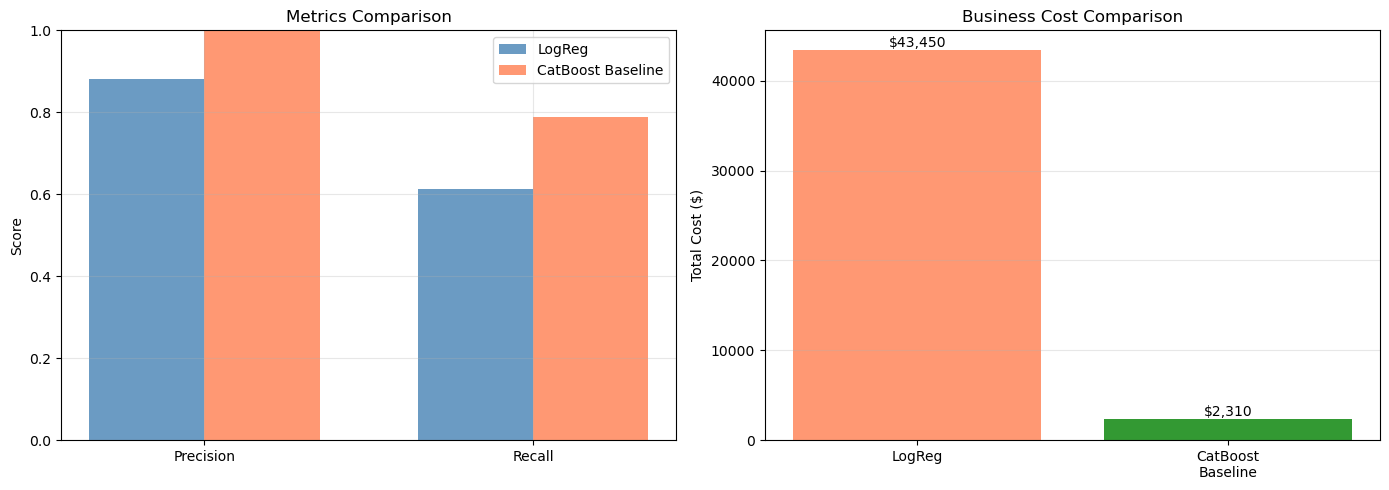


Results saved:
  - results/figures/catboost_baseline_vs_logreg.png
  - results/catboost_baseline_comparison.json
  - results/catboost_baseline_comparison.csv


In [14]:
# Comparison Visualization
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Plot 1: Metrics comparison
metrics_names = ['Precision', 'Recall']
logreg_vals = [logreg_precision, logreg_recall]
catboost_vals = [test_results['precision'], test_results['recall']]

x = np.arange(len(metrics_names))
width = 0.35

axes[0].bar(x - width/2, logreg_vals, width, label='LogReg', alpha=0.8, color='steelblue')
axes[0].bar(x + width/2, catboost_vals, width, label='CatBoost Baseline', alpha=0.8, color='coral')
axes[0].set_ylabel('Score')
axes[0].set_title('Metrics Comparison')
axes[0].set_xticks(x)
axes[0].set_xticklabels(metrics_names)
axes[0].legend()
axes[0].grid(True, alpha=0.3)
axes[0].set_ylim([0, 1.0])

# Plot 2: Cost comparison
models = ['LogReg', 'CatBoost\nBaseline']
costs = [logreg_results['total_cost'], int(test_results['total_cost'])]
colors = ['green' if c == min(costs) else 'coral' for c in costs]

axes[1].bar(models, costs, alpha=0.8, color=colors)
axes[1].set_ylabel('Total Cost ($)')
axes[1].set_title('Business Cost Comparison')
axes[1].grid(True, alpha=0.3, axis='y')

for i, (model, cost) in enumerate(zip(models, costs)):
    axes[1].text(i, cost, f'${cost:,.0f}', ha='center', va='bottom')

plt.tight_layout()
plt.savefig('../../results/figures/catboost_baseline_vs_logreg.png', dpi=300, bbox_inches='tight')
plt.show()

# Save comparison results
comparison_results = {
    'logistic_regression': {
        'precision': float(logreg_precision),
        'recall': float(logreg_recall),
        'total_cost': logreg_results['total_cost'],
        'fp': logreg_results['false_positives'],
        'fn': logreg_results['false_negatives'],
        'tp': logreg_results['true_positives'],
        'tn': logreg_results['true_negatives']
    },
    'catboost_baseline': {
        'precision': float(test_results['precision']),
        'recall': float(test_results['recall']),
        'pr_auc': float(test_results['pr_auc']),
        'total_cost': int(test_results['total_cost']),
        'fp': int(test_results['fp']),
        'fn': int(test_results['fn']),
        'tp': int(test_results['tp']),
        'tn': int(test_results['tn'])
    },
    'cost_savings': {
        'absolute': cost_diff,
        'percentage': cost_reduction_pct
    }
}

# Save to JSON
with open('../../results/catboost_baseline_comparison.json', 'w') as f:
    json.dump(comparison_results, f, indent=2)

# Also save CSV
comparison_df.to_csv('../../results/catboost_baseline_comparison.csv', index=False)

print("\nResults saved:")
print("  - results/figures/catboost_baseline_vs_logreg.png")
print("  - results/catboost_baseline_comparison.json")
print("  - results/catboost_baseline_comparison.csv")
